# Labelling stroke units

This notebook gives examples of how to label the stroke unit names on a map.

The two examples on this page are:
+ Writing a text label on the map above each stroke unit marker.
+ Giving each stroke unit a unique marker and printing its full long name in a legend.

## Notebook setup

In [1]:
import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.plot

import pandas as pd
import matplotlib.pyplot as plt
import os

## Load the stroke unit data

Postcodes, stroke team names, services etc. are stored in this dataframe:

In [2]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

Coordinates of each stroke unit are stored in here:

In [3]:
gdf_units = stroke_maps.load_data.stroke_unit_coordinates()

Merge the unit names and services into the coordinates:

In [4]:
gdf_units = pd.merge(
    gdf_units, df_units,
    left_index=True, right_index=True, how='right'
)

In [5]:
gdf_units.head(3).T

postcode,RM70AG,E11BB,SW66SX
BNG_E,551110,534833,524227
BNG_N,187777,181799,176487
Latitude,51.568622,51.519026,51.473716
Longitude,0.178914,-0.058075,-0.212722
geometry,POINT (551110 187777),POINT (534833 181799),POINT (524227 176487)
stroke_team,Havering and Redbridge University Hospitals NH...,The Royal London Hospital,"Charing Cross Hospital, London"
ssnap_name,Queens Hospital Romford HASU,Royal London Hospital HASU,Charing Cross Hospital HASU
hospital_city,Romford,Royal London,Charing Cross
use_ivt,1,1,1
use_mt,1,1,1


## Non-overlapping text labels

Notes:
+ On a small (in dimensions) figure, this method runs fairly slowly (a few tens of seconds) and takes increasingly long and gives worse results when there are more very long names in the labels. When the figure size is larger, the method runs more quickly. Presumably this is because it has less jiggling around of the labels to attempt.

First load the outline of England and Wales:

In [6]:
gdf_ew = stroke_maps.load_data.englandwales_outline()

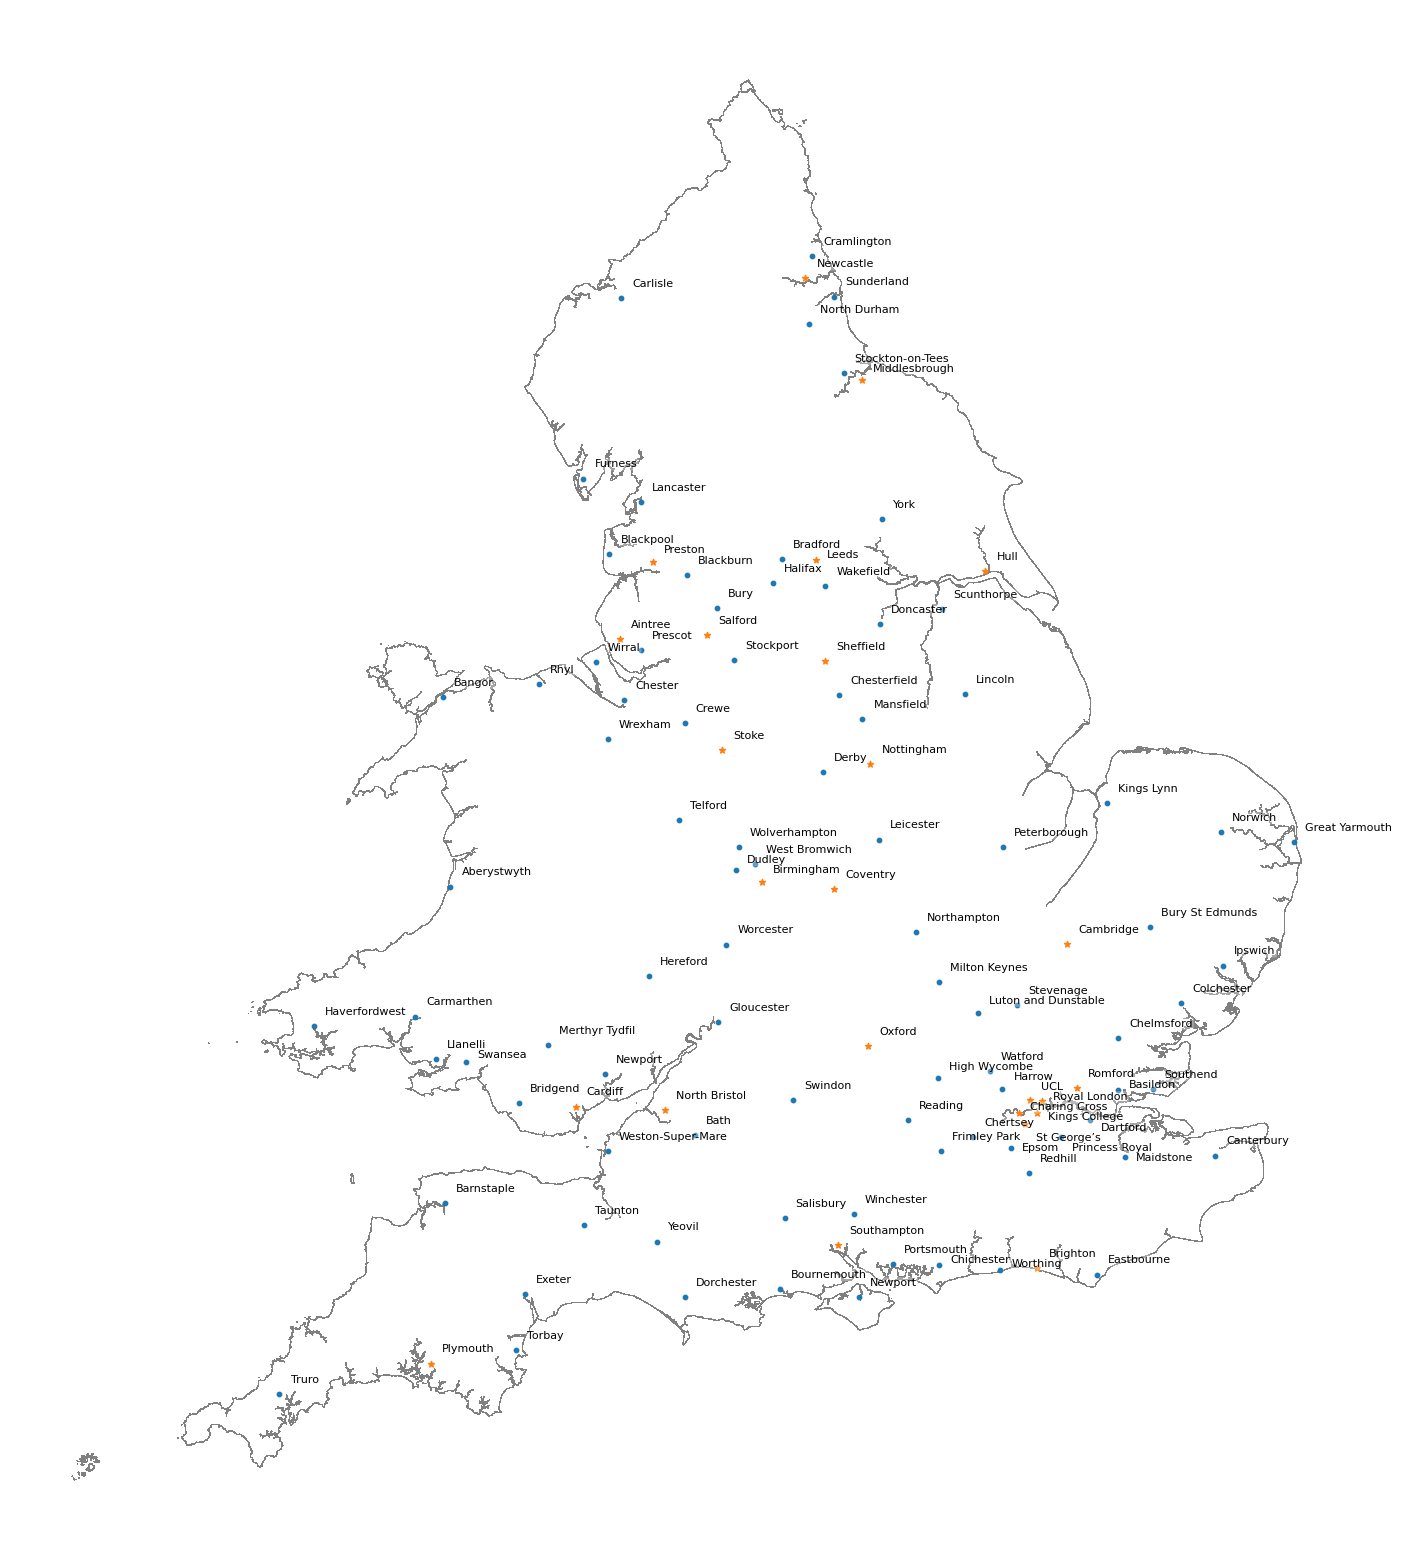

In [7]:
# Make the figsize enormous to give the labels breathing room.
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the country outlines:
gdf_ew.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    facecolor='none',
    edgecolor='grey',
    linewidth=0.2,
    )

# Pick out which stroke units to plot:
mask_ivt = ((gdf_units['use_ivt'] == 1) & (gdf_units['use_mt'] == 0))
mask_mt = (gdf_units['use_mt'] == 1)

# IVT units:
ax.scatter(
    gdf_units.loc[mask_ivt, 'geometry'].x,
    gdf_units.loc[mask_ivt, 'geometry'].y,
    marker='o',
    label='IVT unit',
    s=10,  # size
    )

# MT units:
ax.scatter(
    gdf_units.loc[mask_mt, 'geometry'].x,
    gdf_units.loc[mask_mt, 'geometry'].y,
    marker='*',
    label='MT unit',
    s=20,  # size
    )

ax = stroke_maps.plot.add_nonoverlapping_text_labels(
    gdf_units.loc[mask_ivt | mask_mt], ax, 'hospital_city', y_step=0.05, fontsize=8)

# Remove the axis border, ticks, labels...
ax.axis('off')

plt.show()

## Short codes and a long legend

Stroke units tend to have long names and it's difficult to fit these onto a map, let alone to see anything else that's on the map behind the labels.

Instead mark each stroke unit with its own marker and make a long legend that has the full names.

Import a list of short codes that we have invented:

In [8]:
df_unit_codes = pd.read_csv(os.path.join('data_for_docs', 'stroke_units_short_codes.csv'))

df_unit_codes.head(3)

,postcode,stroke_team,ssnap_name,short_code
0,B152TH,"Queen Elizabeth Hospital, Birmingham",Queen Elizabeth Hospital Edgbaston,QE
1,B714HJ,"Sandwell District Hospital, West Bromwich",Sandwell District Hospital,SW
2,B95SS,Birmingham Heartlands Hospital,Birmingham Heartlands Hospital,BM


Merge these into the geodataframe:

In [9]:
gdf_units = pd.merge(gdf_units, df_unit_codes, on='ssnap_name', how='left')

The legend will contain these contents:

In [10]:
gdf_units[['short_code', 'ssnap_name']].set_index('short_code')

,ssnap_name
short_code,
HV,Queens Hospital Romford HASU
RL,Royal London Hospital HASU
CC,Charing Cross Hospital HASU
KC,King's College Hospital HASU
PR,Princess Royal University Hospital HASU
...,...
PP,Prince Philip Hospital
WW,West Wales General
WB,Withybush General Hospital


Add a column to the `gdf_units` GeoDataFrame that sets the marker shape for each unit. Set IVT units to a circle and MT units to a star.

In [11]:
# Pick out which stroke units to plot:
mask_ivt = ((gdf_units['use_ivt'] == 1) & (gdf_units['use_mt'] == 0))
mask_mt = (gdf_units['use_mt'] == 1)
mask = mask_ivt | mask_mt

In [12]:
gdf_units['marker'] = 'o'  # circle
gdf_units.loc[mask_mt, 'marker'] = '*'  # star

The plot:

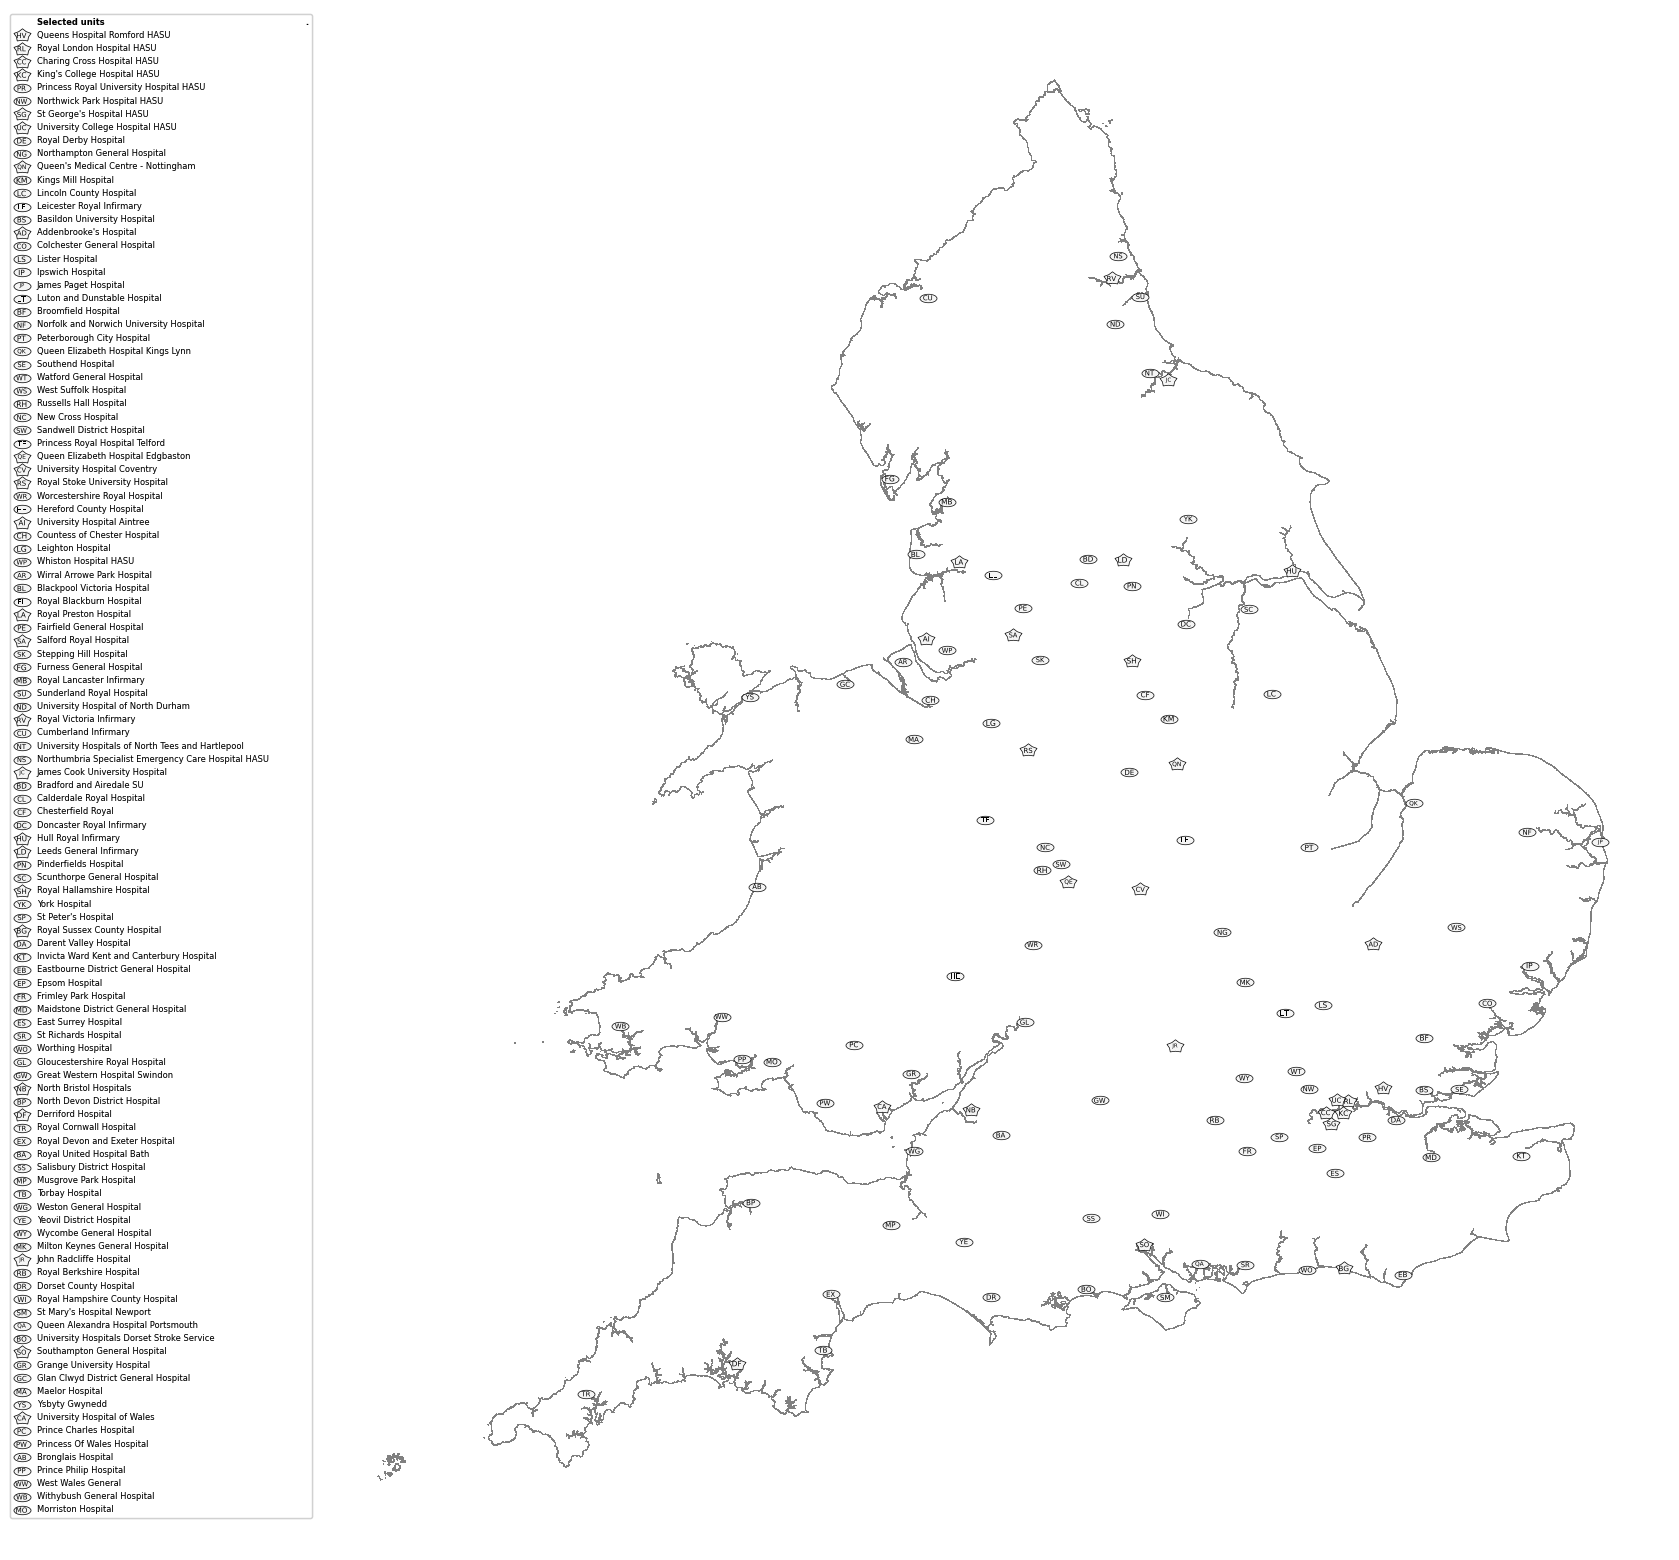

In [13]:
# Make the figsize enormous to give the labels breathing room.
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the country outlines:
gdf_ew.plot(
    ax=ax,              # Set which axes to use for plot
    antialiased=False,  # Avoids artefact boundary lines
    facecolor='none',
    edgecolor='grey',
    linewidth=0.2,
    )

ax, handles_scatter_us = stroke_maps.plot.scatter_units(
    ax,
    gdf_units[mask],
    return_handle=True,
    # The following kwargs are passed to plt.scatter():
    facecolor='WhiteSmoke',
    edgecolor='k',
    )

ax, handles_us, labels_us = stroke_maps.plot.draw_labels_short(
    ax,
    gdf_units.loc[mask, 'geometry'],    # coordinates
    gdf_units.loc[mask, 'short_code'],  # text for each marker
    gdf_units.loc[mask, 'ssnap_name'],  # long name for the legend
    # The following kwargs are passed to plt.scatter():
    s=10,  # label size
    color='k',
    # bbox=dict(facecolor='WhiteSmoke', edgecolor='r'),
)

section_labels = ['Selected units' + ' ' * 70 + '.']
handles_lists = [
    [handles_scatter_us, handles_us]
]
labels_lists = [labels_us]

leg2 = stroke_maps.plot.create_units_legend(
    ax,
    handles_lists,
    labels_lists,
    section_labels,
    # The following kwargs are passed to plt.legend():
    fontsize=6,
    bbox_to_anchor=[0.0, 1.0],
    loc='upper right'
    )


# Remove the axis border, ticks, labels...
ax.axis('off')

# Add the legend as an "extra artist" so that bbox_inches='tight' line
# in savefig() doesn't cut off the legends.
# Adding legends with ax.add_artist() means that the
# bbox_inches='tight' line ignores them.
extra_artists = (leg2, )

save_fig = False
if save_fig:
    # Include extra artists so that bbox_inches='tight' line
    # in savefig() doesn't cut off the legends.
    # Adding legends with ax.add_artist() means that the
    # bbox_inches='tight' line ignores them.
    plt.savefig(
        'output/map.png',
        bbox_extra_artists=extra_artists,
        dpi=300, bbox_inches='tight'
        )

# Add dummy axis to the sides so that
# extra_artists are not cut off when plt.show() crops.
fig = stroke_maps.plot.plot_dummy_axis(fig, ax, extra_artists[0], side='left')
plt.show()
